# Test challenge_seasonality by Javier Martinez

For answering the requested case of study I have programmed a python file called "BW7_toolbox.py" that is attached in my submission. This file contains two functions: correlation_study and seasons_study. Each one is the answer for each of the question suggested in the case of study. In the same project there is also a __init__ file just for the sake of generating a python package.

To execute the functions just unzip the file in the folder where regularly is used as a python path and use "import BW7_toolbox as BW7" to add it to your project. Once in your project you could call the evaluation of the solutions as BW7.correlation_study(filename) or BW7.seasons_study(filename). By default the data for this case of study will be loaded but any csv file that is in the same folder that the python files coudl be also used just by using the proper filename (with the csv extension as part of the name). 

All the plots during the execution will be executed in different windows to allow better insight/control of the plots. 

## Requirements

I would like to add this paragraph just to let you know the version of the pacakges used for this test. It is something I forgot but that could be critical for running and having similar results. 

* Python Interpreter 2.7.12
* Numpy 1.11.3
* Pandas 0.19.2
* Matplotlib 1.5.1
* Seaborn 0.7.1
* Scipy 0.18.1
* Statsmodels 0.8.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

import scipy.signal as sgn
import scipy.stats as stat
import matplotlib.gridspec as grds


import statsmodels.tsa.stattools as sta



sns.set_style("whitegrid")

In [2]:
%matplotlib notebook

In [3]:
# Loading the data
data = pd.read_csv('challenge-data-v2.csv', index_col='event_date',parse_dates = True)


# Taking a look into the first elements of the data to know more about the structure
data.head()

# Changing the name of the colums to a more suitable (shorter) form
data.columns = ['sups','moff','mon','hd']

In [4]:
data.describe()

,sups,moff,mon
count,1155.000000,282.000000,1155.000000
mean,8054.577489,98884.865284,334811.893541
std,2093.419767,71107.830804,152979.099583
min,3973.000000,0.000000,40243.090000
25%,6657.500000,55285.487500,234232.175000
50%,7639.000000,84413.085000,314120.800000
75%,8967.500000,123233.000000,430718.990000
max,26348.000000,446191.350000,975192.300000


In [5]:
for feature in data.columns:
    if data[feature].values.dtype != 'object':
        scale_factor = np.round(np.log10(np.mean(data[feature])))
        data[feature] = data[feature] / 10**scale_factor
        print('The feature: '+feature+' was rescaled by a factor of '+str(10**scale_factor))
print('IMPORTANT: Take these rescaling in account when reading the plots')

The feature: sups was rescaled by a factor of 10000.0
The feature: moff was rescaled by a factor of 100000.0
The feature: mon was rescaled by a factor of 1000000.0
IMPORTANT: Take these rescaling in account when reading the plots


In [6]:
# Some statistics
print(data.columns[data.columns!='hd'])

data.head()

Index([u'sups', u'moff', u'mon'], dtype='object')


,sups,moff,mon,hd
event_date,,,,
2014-01-01,0.4246,NaN,0.041934,NewYearsDay
2014-01-02,0.6569,NaN,0.054117,NaN
2014-01-03,0.7466,NaN,0.051634,NaN
2014-01-04,0.6911,NaN,0.047323,NaN
2014-01-05,0.5929,NaN,0.048324,NaN


# Q1) 	 CORRELATION 	

## Q1.1) Using Python and the libraries and packages of your own choice, write a well-structured and readable program that can be used to analyse the data set for correlations between the time series. The program should work with data files that are similar, but not necessarily identical to the sample provided. Your response should include the program itself and brief instructions about any dependencies that should be installed before running it.


### Proposal


The idea behind the solution of this first question is to provide the user the most usefol plots and information to observe any correlation. With that in mind after the execution of "correlation_study" the next plots will be presented on the screen (different windows):
* Temporal distribution by year. The idea of this plot is to provide the user a broad overview of the activity of the different features. For that reason each feature has assigned one colum while the rows represent different distributions:
    * First row, distribution of features accross the year for different years.
    * Second row, distribution of the features per month for different years. 
    * Third row, distribution of the featyres during the weekdays for different years. 

* Monthly distribution of features. In this plot I present the monthly distribution of the different features. The idea here is to provide some insight into the data before the next plot. 
* Monthly features crosscorrelations. This plot address explicitly the question of the correlation between the different time series of the data set in the temporal scale of a month. I did it in this way to address that the data is non-stationary and hence this relationship depends strongly of the period of the year (month). Take in account that the first zero lag is from the first time series mentioned in the plot to the second. Then if you observed a peak in the positive side of the crosscorrelograms should be interpreted as a larger probability of having the event two in that lag of time respect the first time series mentioned in the plot. The cross correlations are computed to have the same number of samples than the original time series (I find a 'full' version non informative in this time scale). Whenever you find an empty plot is because there was not enough collected data to calculate any statistics. 

* Rolling corelation coefficient and weekly activity of the different features. In my opinion this is the more informative than the previous one but address the problem a bit different. This figure shows the moving correlation coefficient (with a temporal window of 14 days, 2 weeks) together with the dynamics of the features (resampled to weekly activity for the sake of smooth it). Interestingly in this way it is possible to extract some statistics on what it is going with this coefficient divided by years. This is shown in the last row of the plot. This row presents the distributions of the correlations during the year and provide a nice picture of the business choices taken during that year. It also measure the effectiveness of whatever event because this will have an impact in the shape and other moments of those distributions. The median (assuming that in general the situation wont be gaussian) is shown as a parameter for decision making (or index of correlation for a year). In the cases the skweness of the distribution is close to a gaussian, a normal distribution will be fitted to the data (and the mean and variance of the distribution will be shown). In addition to this in the console there will be reflected also the activity of the different moments of the distributions per year. 

These plots are just tools, a window to the observer to have an insight on what it is happening with the correlation of the features. 

Non-numeric features will not be considered for this study. That is the reason for discarding (not using) the holydays.

In the next cells I present the same code that is used in the function that will help in the reporting of the specific case of study.

There is some redundancy in the code but this was done with the idea of reusability of blocks of code, not only for me but for other developers too.


<IPython.core.display.Javascript object>


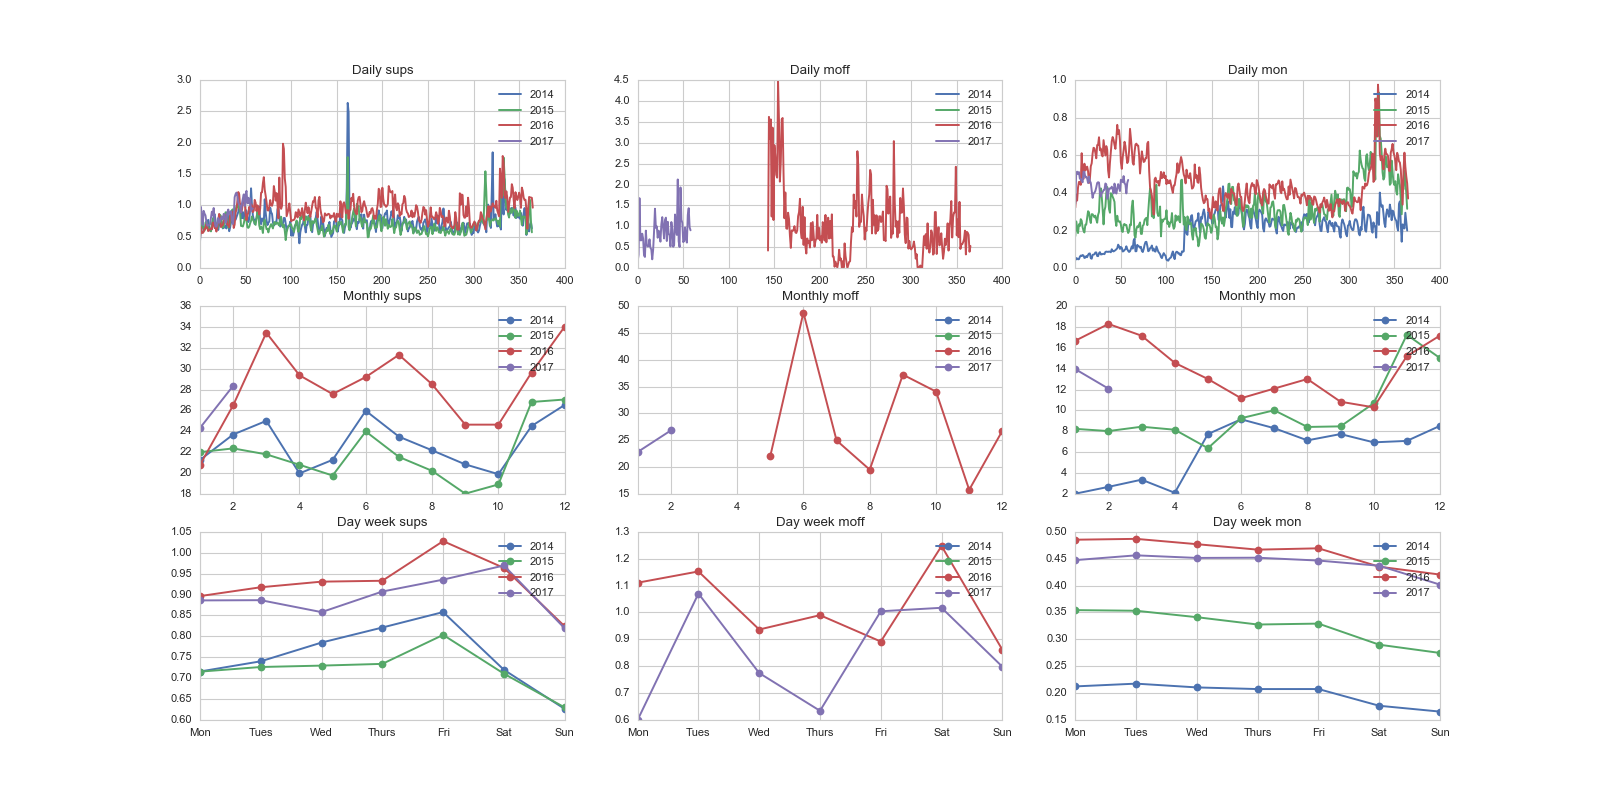

In [7]:
# *****************************************************
# Computation of the distributions per year for the different features
years = np.unique(data.index.year)


# Definition of the figure.
figid = plt.figure('Temporal distributions by year', figsize=(20, 10))

# Definition of the matrix of plots. In this case the situation is more complex that is why I need to define a
# matrix. It will be a dim[2x3] matrix.
col = len(data.columns[data.columns!='hd'])
gs = grds.GridSpec(3,col)

for i in range(col):
    
    ax1 = plt.subplot(gs[0, i])
    ax2 = plt.subplot(gs[1,i])
    
    legend =[]
    for y in years: 
        dat = data[data.columns[i]][str(y)].values
        ax1.plot(np.arange(len(dat)),dat,'-')
        legend.append(str(y))
    ax1.legend(legend)
    ax1.set_title('Daily '+data.columns[i])

    legend =[]
    for y in years:
        dat = data[data.columns[i]][str(y)].resample('M').sum()
        ax2.plot(np.arange(len(dat))+1,dat,'-o')
        legend.append(str(y))
    ax2.legend(legend)
    ax2.set_title('Monthly '+data.columns[i])
    plt.xlim([1,12])

    ax3 = plt.subplot(gs[2,i])
    legend =[]
    for y in years:
        dat = data[data.columns[i]][str(y)]
#         dat = dat.groupby(data.index.dayofweek).mean()
        dat = dat.groupby(dat.index.dayofweek).mean()
        dat.index=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
        dat.plot(style='-o')
        legend.append(str(y))
    ax3.legend(legend)
    ax3.set_title('Day week '+data.columns[i])


<IPython.core.display.Javascript object>


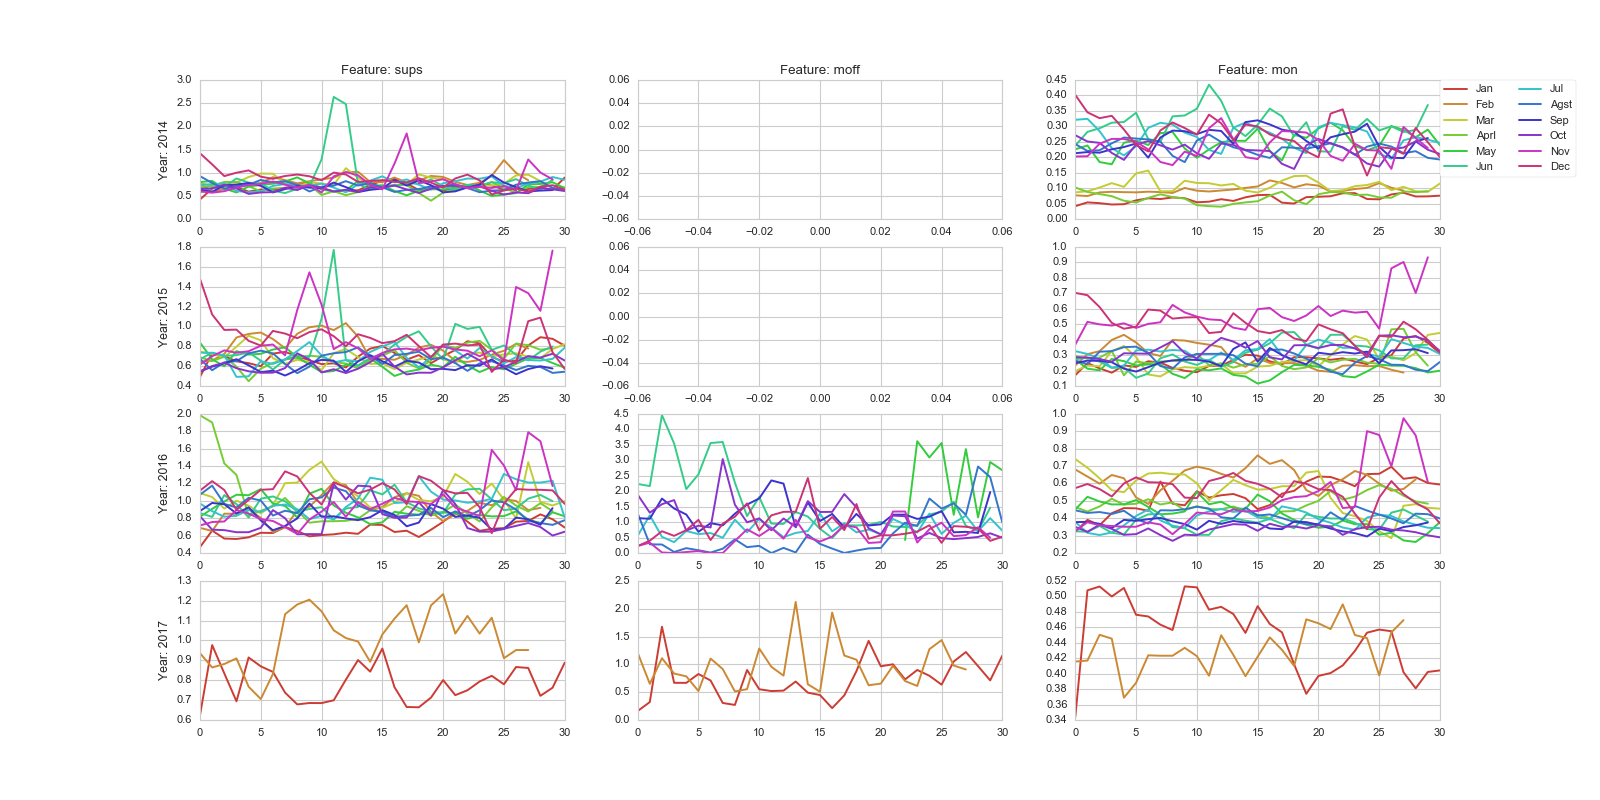

In [8]:
# *****************************************************
# Computation of the distribution of activity per month for the different time series that are present in the data
years = np.unique(data.index.year)


# Definition of the figure.
figid = plt.figure('Monthly distribution of features',figsize=(20, 10))

# Definition of the matrix of plots. In this case the situation is more complex that is why I need to define a
# matrix. It will be a dim[2x3] matrix.
col = len(data.columns[data.columns!='hd'])
rows = len(years) 
gs = grds.GridSpec(rows,col)
months=['Jan','Feb','Mar','Aprl','May','Jun','Jul','Agst','Sep','Oct','Nov','Dec']
colors = sns.hls_palette(12, l=.5, s=.6)

for c in range(col):
    for r in range(rows):
        ax1 = plt.subplot(gs[r, c])

        dat_year = data[data.columns[c]][str(years[r])]

        for m in range(1,13):
#             print m
            dat = dat_year[dat_year.index.month==m].values
            ax1.plot(np.arange(len(dat)),dat,'-', color=colors[m-1])
        if r==0 and c==col-1:
            ax1.legend(months, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.,ncol=2, fancybox=True,frameon=True)
  
        if c==0:
            ax1.set_ylabel('Year: '+str(years[r]))
            
        if r==0:
            ax1.set_title('Feature: '+str(data.columns[c]))

<IPython.core.display.Javascript object>


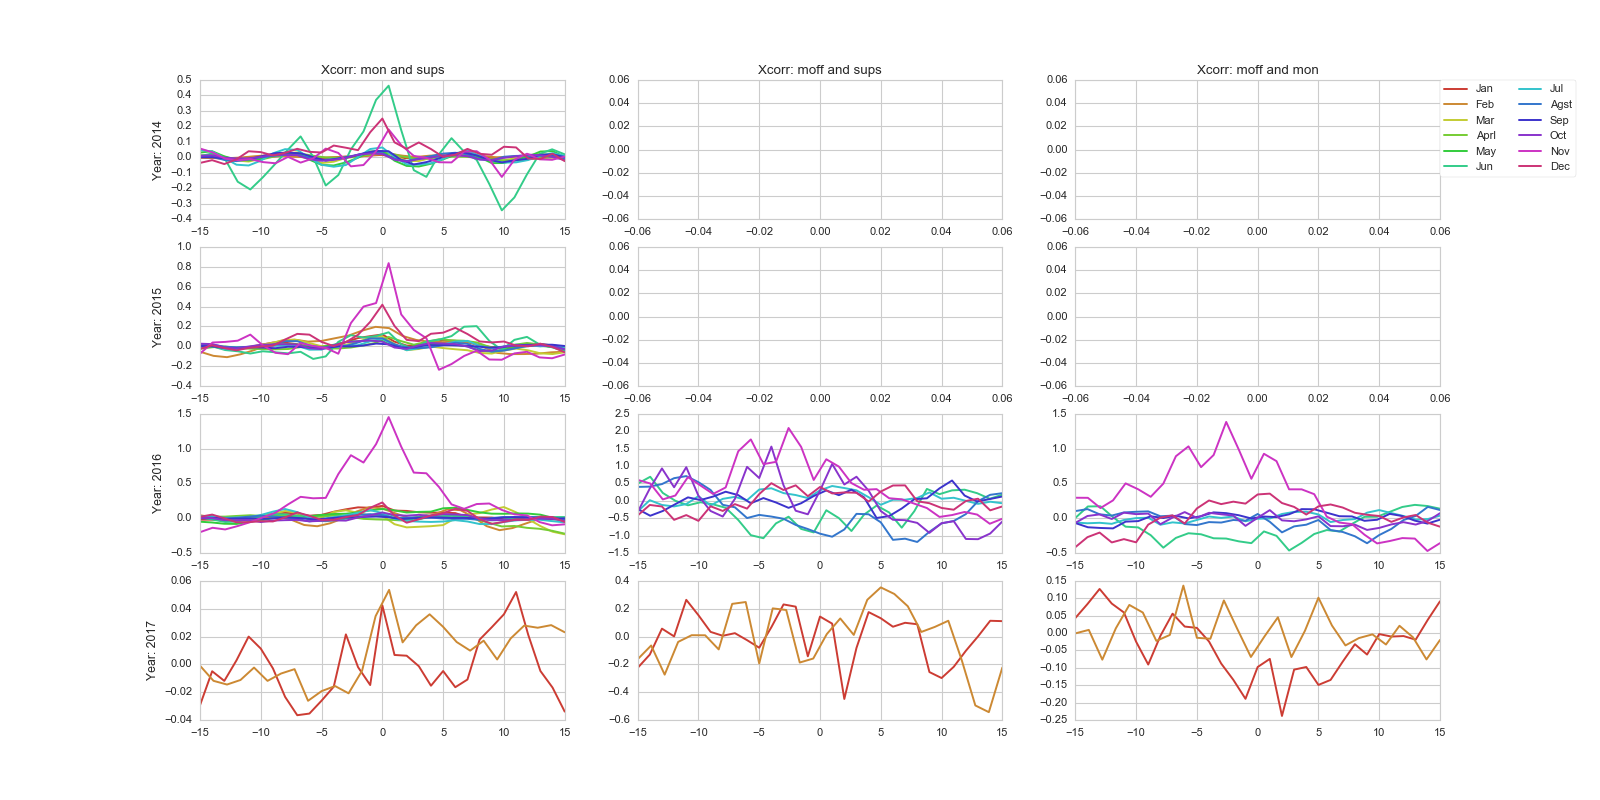

In [16]:
# *****************************************************
# Computation of the distribution of cross correlations per month for the different time series that are present in the data
years = np.unique(data.index.year)


# Definition of the figure.
figid = plt.figure('Monthly features cross-correlations', figsize=(20, 10))

# Definition of the matrix of plots.
feature1= [2,1,1]
feature2 =[0,0,2]


col = len(data.columns[data.columns!='hd'])
rows = len(years) 

gs = grds.GridSpec(rows,col)
months=['Jan','Feb','Mar','Aprl','May','Jun','Jul','Agst','Sep','Oct','Nov','Dec']
# colors = sns.color_palette("Set2", 12)
colors = sns.hls_palette(12, l=.5, s=.6)

for c in range(col):
    for r in range(rows):
        ax1 = plt.subplot(gs[r, c])

        dat_year_feat1 = data[data.columns[feature1[c]]][str(years[r])]
        dat_year_feat2 = data[data.columns[feature2[c]]][str(years[r])]
        
        for m in range(1,13):
            dat_feat1 = dat_year_feat1[dat_year_feat1.index.month==m].values
            dat_feat1= np.subtract(dat_feat1,np.mean(dat_feat1))
            dat_feat2 = dat_year_feat2[dat_year_feat2.index.month==m].values
            dat_feat2= np.subtract(dat_feat2,np.mean(dat_feat2))
            if len(dat_feat1) and len(dat_feat2):
                dat = sgn.correlate(dat_feat1,dat_feat2,mode='same')
                ax1.plot(np.linspace(-15,15,len(dat)),dat,'-', color=colors[m-1])
        if c==0:
            ax1.set_ylabel('Year: '+str(years[r]))
        if r==0 and c==col-1:
            ax1.legend(months, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.,ncol=2, fancybox=True,frameon=True)
        if r==0:
            ax1.set_title('Xcorr: '+str(data.columns[feature1[c]])+' and '+str(data.columns[feature2[c]]))

<IPython.core.display.Javascript object>


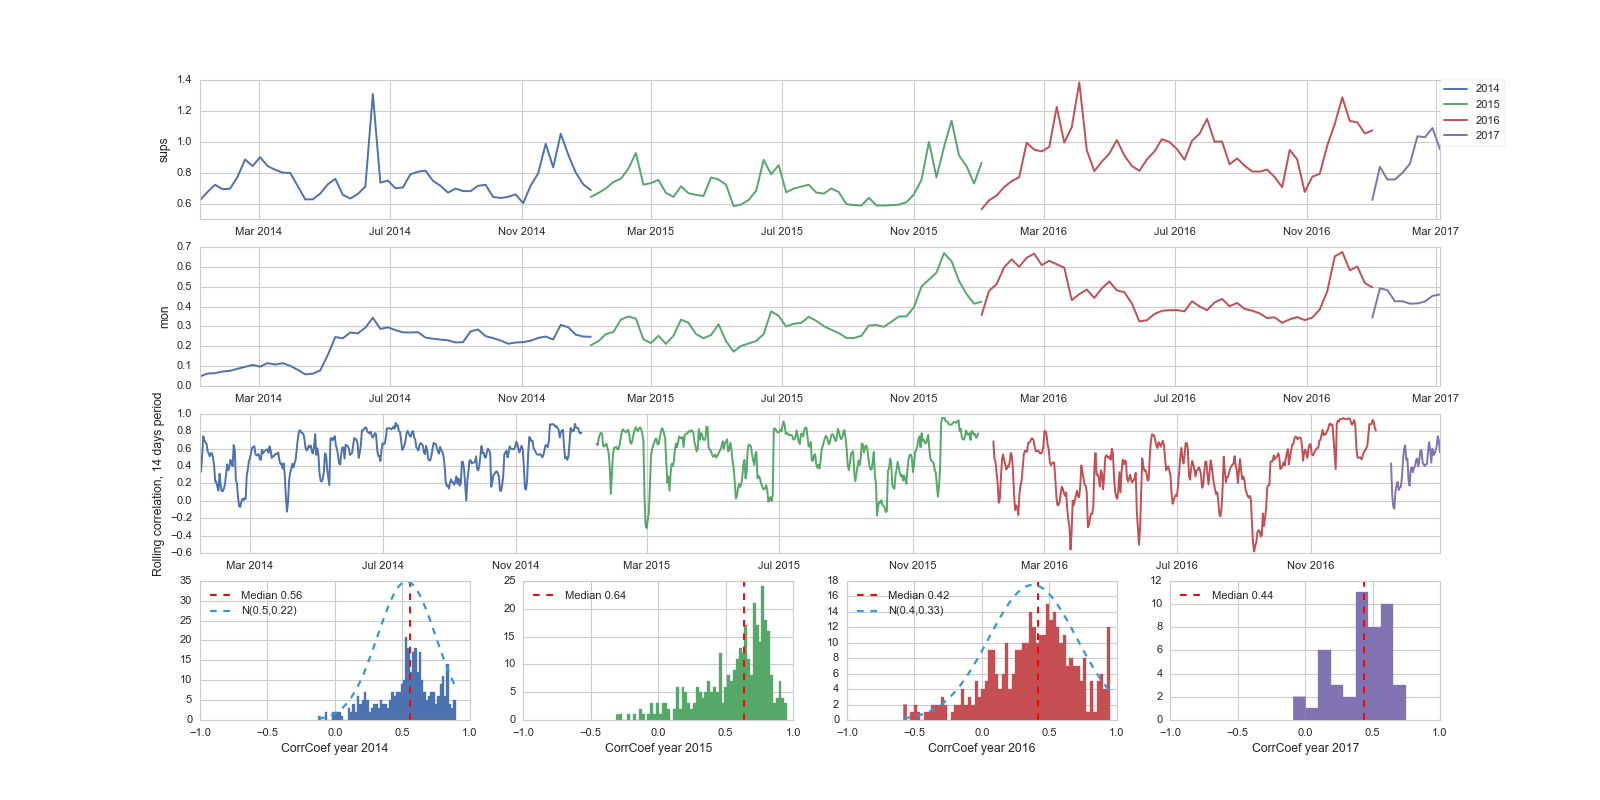

/home/javier/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14).corr(other=<Series>)


-------------------------------------------------
Correlation distribution for year 2014
('Mean:', 0.5327463141316191)
('Median:', 0.5579492586566226)
('Standard deviation:', 0.21572067161109418)
('Kurtosis:', -0.042142352797982063)
('Skewness:', -0.63819609959642376)
Normal distribution fitted!
mu=0.532746314132
sigma=0.215414032264
-------------------------------------------------
Correlation distribution for year 2015
('Mean:', 0.56389935886974873)
('Median:', 0.6351669883205653)
('Standard deviation:', 0.2593490791520523)
('Kurtosis:', 0.44958587411626105)
('Skewness:', -1.0051039029321127)
-------------------------------------------------
Correlation distribution for year 2016
('Mean:', 0.37852439741578708)
('Median:', 0.4174400433755004)
('Standard deviation:', 0.32651191457093248)
('Kurtosis:', 0.060081200058469175)
('Skewness:', -0.53527690270242101)
Normal distribution fitted!
mu=0.378524397416
sigma=0.326049105104
-------------------------------------------------
Correlation 

<IPython.core.display.Javascript object>


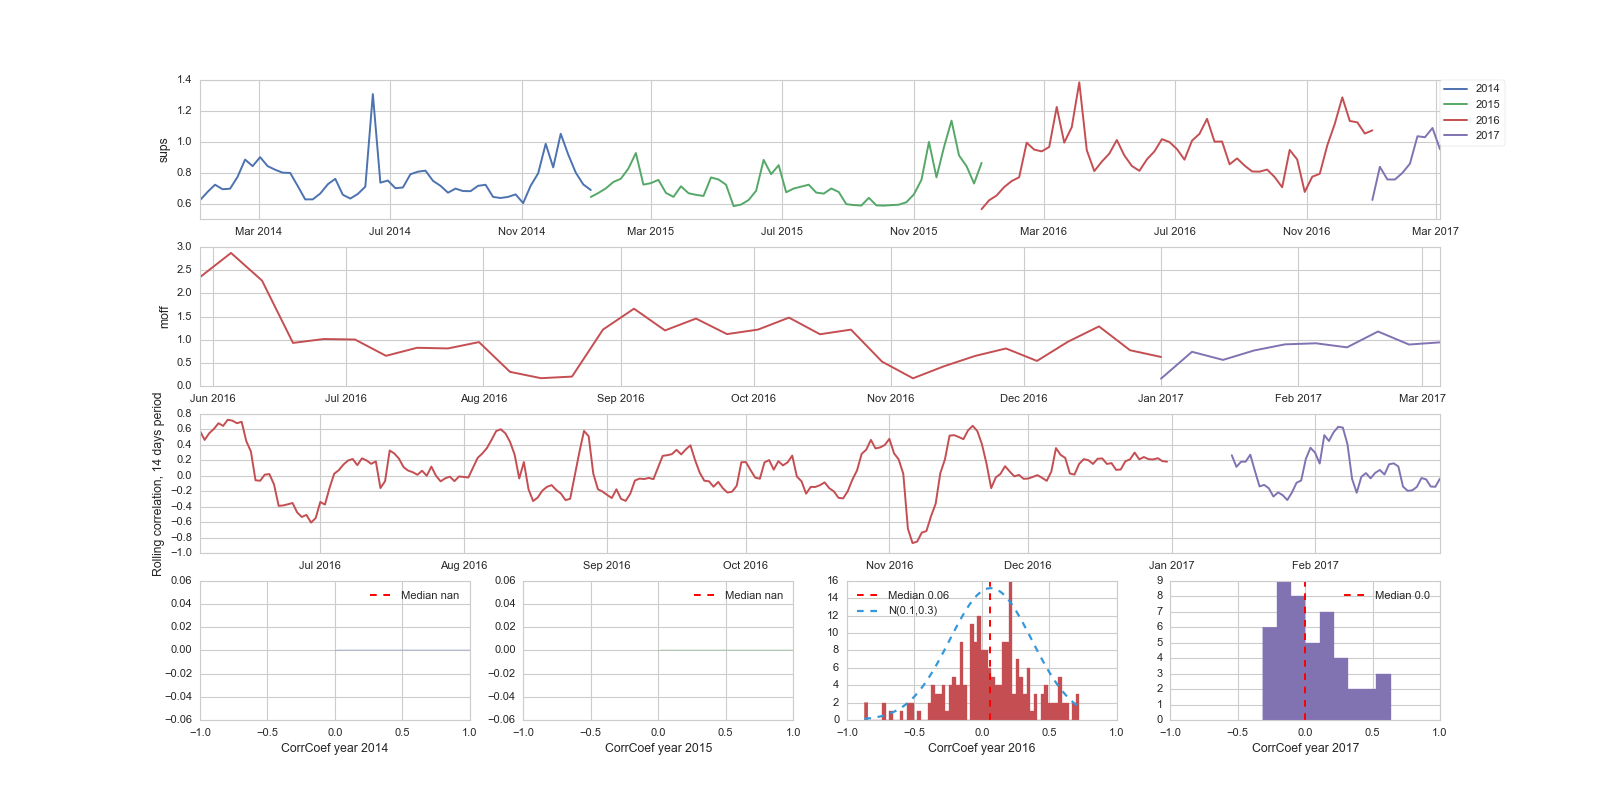

-------------------------------------------------
Correlation distribution for year 2014
('Mean:', nan)
('Median:', nan)
('Standard deviation:', nan)
('Kurtosis:', nan)
('Skewness:', nan)
-------------------------------------------------
Correlation distribution for year 2015
('Mean:', nan)
('Median:', nan)
('Standard deviation:', nan)
('Kurtosis:', nan)
('Skewness:', nan)


/home/javier/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in absolute


-------------------------------------------------
Correlation distribution for year 2016
('Mean:', 0.066776414797463698)
('Median:', 0.059762561962088845)
('Standard deviation:', 0.30562092296379639)
('Kurtosis:', 0.35978955637484944)
('Skewness:', -0.27712749211592491)
Normal distribution fitted!
mu=0.0667764147975
sigma=0.304892385758
-------------------------------------------------
Correlation distribution for year 2017
('Mean:', 0.058652288121089143)
('Median:', 0.0013753580023077132)
('Standard deviation:', 0.24906369948678209)
('Kurtosis:', -0.20500517173863742)
('Skewness:', 0.7438282196990379)


<IPython.core.display.Javascript object>


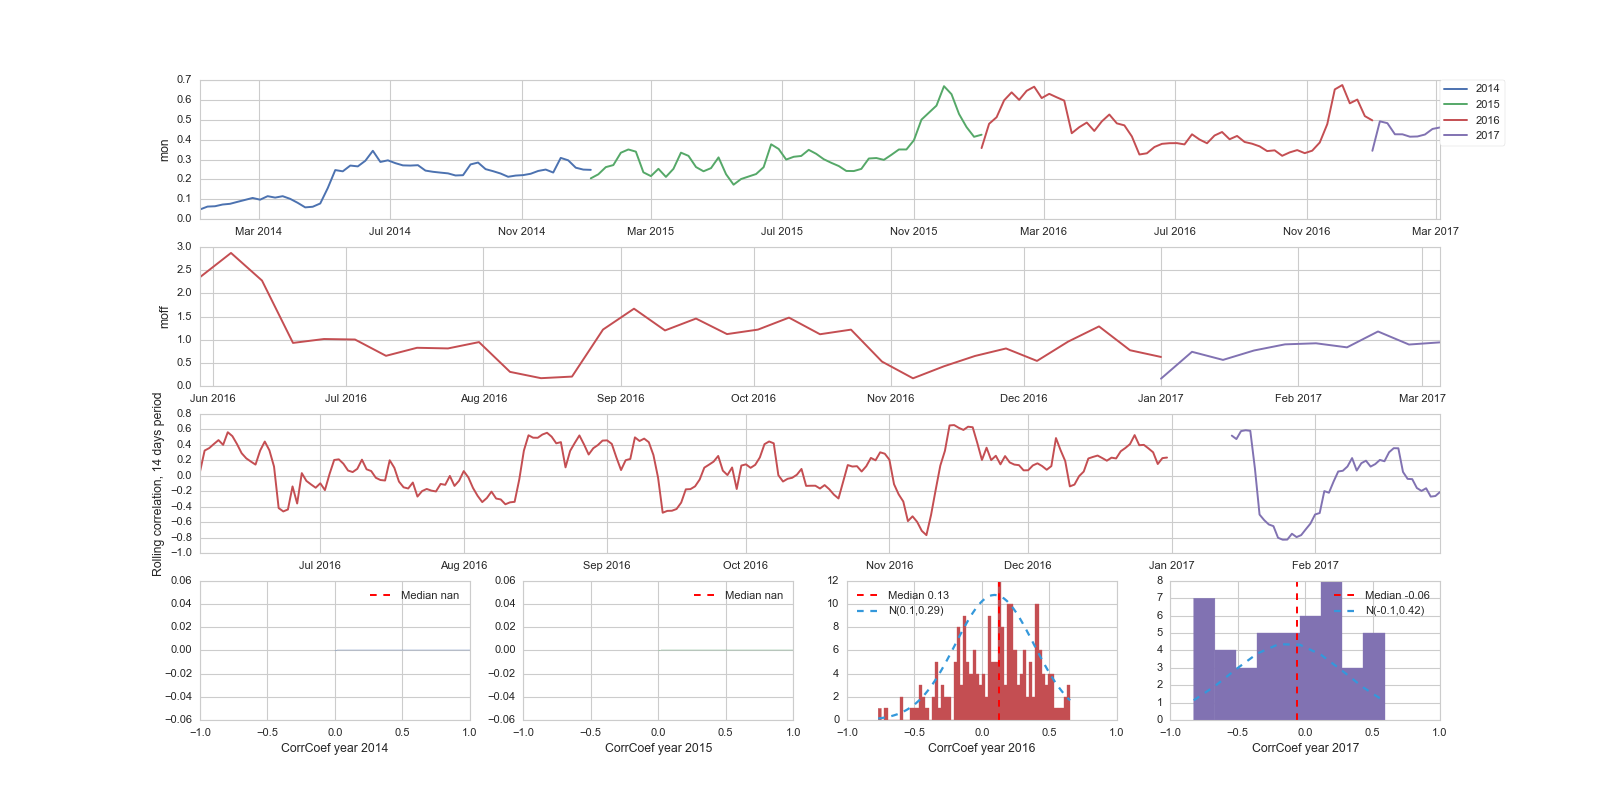

-------------------------------------------------
Correlation distribution for year 2014
('Mean:', nan)
('Median:', nan)
('Standard deviation:', nan)
('Kurtosis:', nan)
('Skewness:', nan)
-------------------------------------------------
Correlation distribution for year 2015
('Mean:', nan)
('Median:', nan)
('Standard deviation:', nan)
('Kurtosis:', nan)
('Skewness:', nan)
-------------------------------------------------
Correlation distribution for year 2016
('Mean:', 0.095331035616609966)
('Median:', 0.12514188531403064)
('Standard deviation:', 0.29157495255713306)
('Kurtosis:', -0.24770159036867945)
('Skewness:', -0.38590234133732232)
Normal distribution fitted!
mu=0.0953310356166
sigma=0.290879898046
-------------------------------------------------
Correlation distribution for year 2017
('Mean:', -0.12615675484656946)
('Median:', -0.05957287970875982)
('Standard deviation:', 0.42969368199267166)
('Kurtosis:', -1.059753895022753)
('Skewness:', -0.14963081961877389)
Normal distribu

In [12]:
# *****************************************************
# Computation of the distribution of activity per month for the different time series that are present in the data
years = np.unique(data.index.year)

# Definition of the matrix of plots.
feature1 = [0,0,2]
feature2 = [2,1,1]

for f in range(len(feature1)):

    figid = plt.figure(
        'Rolling correlation coefficient and weekly activity of ' + data.columns[feature1[f]] + ' and ' + data.columns[
            feature2[f]], figsize=(20, 10))
    rows = len(years)

    gs = grds.GridSpec(4, 4)

    for r in range(rows):
        ax1 = plt.subplot(gs[0, :])
        ax2 = plt.subplot(gs[1, :])
        ax3 = plt.subplot(gs[2, :])

        dat_year_feat1 = data[data.columns[feature1[f]]][str(years[r])]
        dat_year_feat2 = data[data.columns[feature2[f]]][str(years[r])]

        ref = ax1.plot(dat_year_feat1.resample('W'))
        ax2.plot(dat_year_feat2.resample('W'))

        xcorr = pd.rolling_corr(dat_year_feat1, dat_year_feat2, 14)
        ax3.plot(xcorr)

        ax4 = plt.subplot(gs[3, r])
        n, bins, patches = ax4.hist(xcorr.values[np.logical_not(np.isnan(xcorr.values))], bins=np.round(len(xcorr) / 6),
                                    facecolor=ref[0].get_color(), edgecolor=ref[0].get_color())
        mediana = ax4.axvline(np.median(xcorr.values[np.logical_not(np.isnan(xcorr.values))]), color='r', linestyle='--')
        ax4.set_xlim([-1, 1])
        ax4.set_xlabel('CorrCoef year '+str(years[r]))
        ax4.set_label(mediana)

        print('-------------------------------------------------')
        print('Correlation distribution for year ' + str(years[r]))
        print('Mean:', xcorr.mean())
        print('Median:', xcorr.median())
        print('Standard deviation:', xcorr.std())
        print('Kurtosis:', xcorr.kurtosis())  # Kurtosis is mainly related with outliers not with the central peak
        print('Skewness:', xcorr.skew()) #Take in account that this value (has not) HAS the substraction of the skew of a normal distribution (3)

        if (np.abs(xcorr.skew())) < 0.65:
            mu, sigma = stat.norm.fit(xcorr.values[np.logical_not(np.isnan(xcorr.values))])
            print('Normal distribution fitted!')
            print('mu=' + str(mu))
            print('sigma=' + str(sigma))

            fitted_normal = mlab.normpdf(bins, mu, sigma) * np.max(
                xcorr.values[np.logical_not(np.isnan(xcorr.values))])
            # print fitted_normal
            normfit = ax4.plot(bins, fitted_normal * np.max(n), 'r--', linewidth=2, color="#3498db")
            ax4.legend(['Median '+str(round(xcorr.median(),2)), 'N(' + str(round(mu, 1)) + ',' + str(round(sigma, 2)) + ')'], loc='best')
        else:
            ax4.legend(['Median '+str(round(xcorr.median(),2))], loc='best')


    ax1.set_ylabel(data.columns[feature1[f]])
    ax2.set_ylabel(data.columns[feature2[f]])
    ax3.set_ylabel('Rolling correlation, 14 days period')


    ax1.legend(years, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., ncol=1, fancybox=True, frameon=True)


#    Q1.2) Run the program on the provided data sample from PetFood and comment on the output.

The analysis of this data is quite interesting.

The signups distribution along the year suffer from some seasonality in the years with only online adds. When the new offline adds started the distribution is completely different and the total amount of sign ups is increased what looks like 20%. The same happend with the distribution during the days of the week. But with less impact and having always the friday as the larger sign up day. 

Comparing the two methods of advertisements the online seems a stable investment of money with a better prediction on the inpact of the sign ups than the offline methods. These ones consume a big budget of investment and do not provide a correlation with the activity of the sign ups. 

The monthly distribution of all the features shows this situation too. The peaks if sign ups were well stablished before the offline add, but seem to vanish and shows more noisy picture in the last two years.
The investment on online add is really seasonal having usualy minimums during the first month of the year. 


The monthly crosscorrelations show clear that the online services are moderate correlated with the sign ups (response of the customer) during the whole year, following a period of 5 days. The situation is a bit different, though, for november which present high(moderate high for 2014) degree of correlation. In addition the activity of the sign ups is after the zero which indicates a possibility of causation (warning!) of the online add on the behaviour of the consumers. 

The offline shows much noisy uncorrelated picture. There is no structure (periodic) on the crosscorrelogram and the activity of the customers seems to happend BEFORE the major investments on these adds. This is interesting. It could be a proof that the campaign on those media is failing, going fater the noisy behavior of the market or the will of a non expert. It seems like after checking slightly/substantial increasings in signups with moderate spends on the offline, the company decided to invest more or invest in a way less atractive to the customer. It could be also a saturation effect on the decision of the customer that suffer from unnecesary adds on TV. This is specially clear in November but it is a general trend. 

The relation between the two ways of adds seems uncorrelated except for november 2016 where probably due to the christmas campaing the company invest more money in both...but having only major effect on the customer at the level of the online media. 

The plots of the rolling cross correlation coefficient shows a tendency of better performance and predictability of customer choices with the online adds. The median of the correlation was higher for 2014 and 2015 while there is a decrease of this when the offline add started (2016,2017). Then it is not only that the offline is not really predicting the behaviour of the customer but it seems (well, this is a causal declaration but the data point towards that) that is decreasing the correlation of the customer behavior based on the online media. 

Summarizing, despite the total increasing of sign ups specially after the big first investment. This ofline campaign seems not useful for predicting the behavior of the customers. The first two years the nice are nice and according to the distributions of signups the situation seems to be fitting a Poisson process which is really convenient when one has to scale system (serers, services, etc) with the general queue theory. The new offline adds disrupted this situation and made it more difficult to predict putting almost at random level the investment with the effect on the customer. 


#     Q1.3) Comment on additional approaches that could be used to search for various types of correlations in the data set.

Further ideas that one can use here for correlations:

* Study of the cross-spectral density and coherence
* Study of granger causality
* Study of PCA/ICA-ish analysis on the time series to see any pattern that coud be capturing the variance in a meaningful way
* Use of the statsmodels package to apply some statistical test on the correlation http://statsmodels.sourceforge.net/ I am currently exploring this toolbox but I could not extract the whole potential
* Split the offline spends based on the type of media (TV,newspaper, etc). Probably these media has really different approach from the customer behavior side

# Q2) SEASONS AND CYCLES 	
## Q2.1) Using Python and the libraries and packages of your own choice, write	a well-structured and readable program that can be used to identify periodic behaviour in the “signups” time series. The program should work with data files that are similar, but not necessarily identical to the sample provided. Your response should include the program itself and brief instructions about any dependencies that should be installed to run it.

 

## Proposal

The idea behind the solution the second question is to provide the user the most useful plots and information to observe any seasonality or cycles in the data. With that in mind after the execution of "seasons_study" the next plots will be presented on the screen (different windows):

* Temporal Sign-ups distributions by year. The purpose of this plot is to give certain broad view on the data. It is also used in the previous function because helps to visualize the activity of the different years and why is convenient to split the analysis per year (due to the non-stationarity of the processes). Each row represents:
    * First row, the daily activity of the sign ups during the period of one year (color coded per year).
    * Second row, the monthly activity of the sign ups. This provides a broader view that happend in a wider time scale; ignoring the noisy daily signal some insights could be observed.
    * Third row, the activity of sign ups during the week days. This is a small time scale but helps to see the relevance of certain days of the week. 
    
* Spectral estimators per year. This plots is the core of the idea to capture the seasons and cycles. It is based on the well-known Fourier analysis. Eacho row represent the espectral estimators for each year. The colums represent:
    * The power spectral density of the signal (PSD). This concept capture the general distribution of power of the signal during the observation of time (one year in this case). It provides a first estimator of which spectral components are relevant for the time series. The peaks in frequency represent periods (seasons) of the signal.
    * Spectrogram. This spectral estimator provides slightly more insight in the temporal components of the time series in the frequency domain. Using a sliding window one can compute the Fourier transform on those windows and chunking them together while the window is moving, presenting a 2-D map of time x frequency (x axis for time, y axis for frequency). Using a window of 32 days (samples, just for convenience of being a power of 2) and overlapping each window 80% of the neighbour windows I provide a powerful tool for evaluating the periodicity. 
    * Log10 scale spectrogram. This colum is similar to the previous but in log10 scale to provide no so crispy visual input and observe other components. 

The DC components (f=0) is not shown on the PSD.

These plots are just tools, a window to the observer to have an insight on what it is happening with the sign up periodicity. 

In the next cells I present the same code that is used in the function that will help in the reporting of the specific case of study.

There is some redundancy in the code but this was done with the idea of reusability of blocks of code, not only for me but for other developers too.

<IPython.core.display.Javascript object>


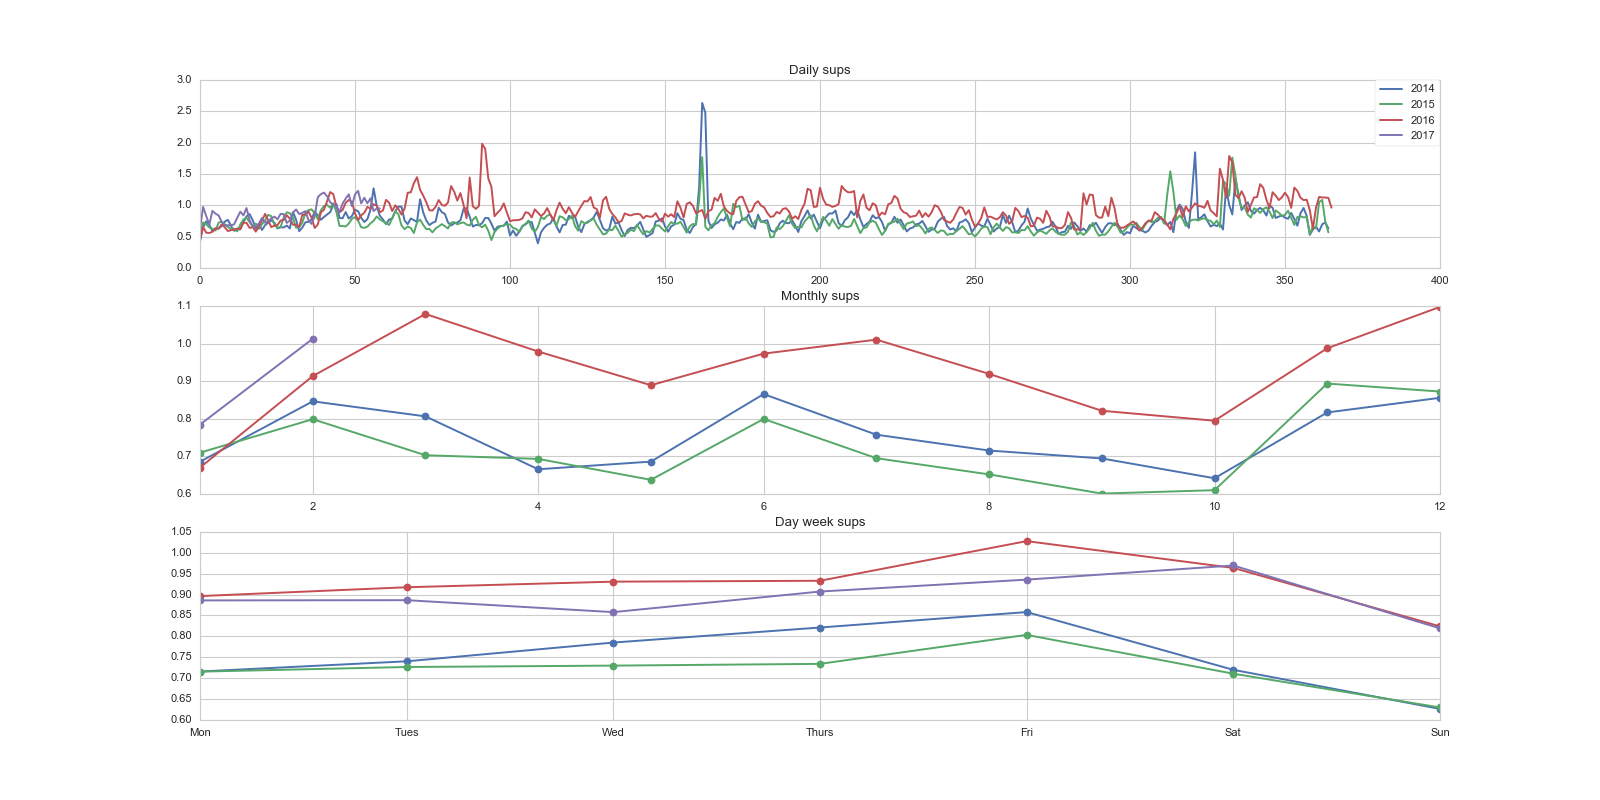

/home/javier/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
.resample() is now a deferred operation
You called values(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


In [13]:
# *****************************************************
# Computation of the distributions per year for sign ups
years = np.unique(data.index.year)


# Definition of the figure.
figid = plt.figure('Temporal Sign-ups distributions by year', figsize=(20, 10))

# Definition of the matrix of plots. In this case the situation is more complex that is why I need to define a
# matrix. It will be a dim[2x3] matrix.
col = len(data.columns[data.columns=='sups'])
gs = grds.GridSpec(3,col)

for i in range(col):
    
    ax1 = plt.subplot(gs[0, i])
    ax2 = plt.subplot(gs[1,i])
    
    legend =[]
    for y in years:
        dat = data[data.columns[i]][str(y)].values
        ax1.plot(np.arange(len(dat)),dat,'-')
        legend.append(str(y))
    ax1.set_title('Daily '+data.columns[i])

    legend =[]
    for y in years:
        dat = data[data.columns[i]][str(y)].resample('M').values
        ax2.plot(np.arange(len(dat))+1,dat,'-o')
        legend.append(str(y))
    ax2.set_title('Monthly '+data.columns[i])
    plt.xlim([1,12])

    ax3 = plt.subplot(gs[2,i])
    legend =[]
    for y in years:
        dat = data[data.columns[i]][str(y)]
        dat1 = dat.groupby(dat.index.dayofweek).mean()    
        dat1.index=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
        dat1.plot(style='-o')
        
        legend.append(str(y))
    ax3.set_title('Day week '+data.columns[i])
    
    if i==0:
        ax1.legend(years, bbox_to_anchor=(1, 1), loc='best', borderaxespad=0.,ncol=1, fancybox=True,frameon=True)



<IPython.core.display.Javascript object>


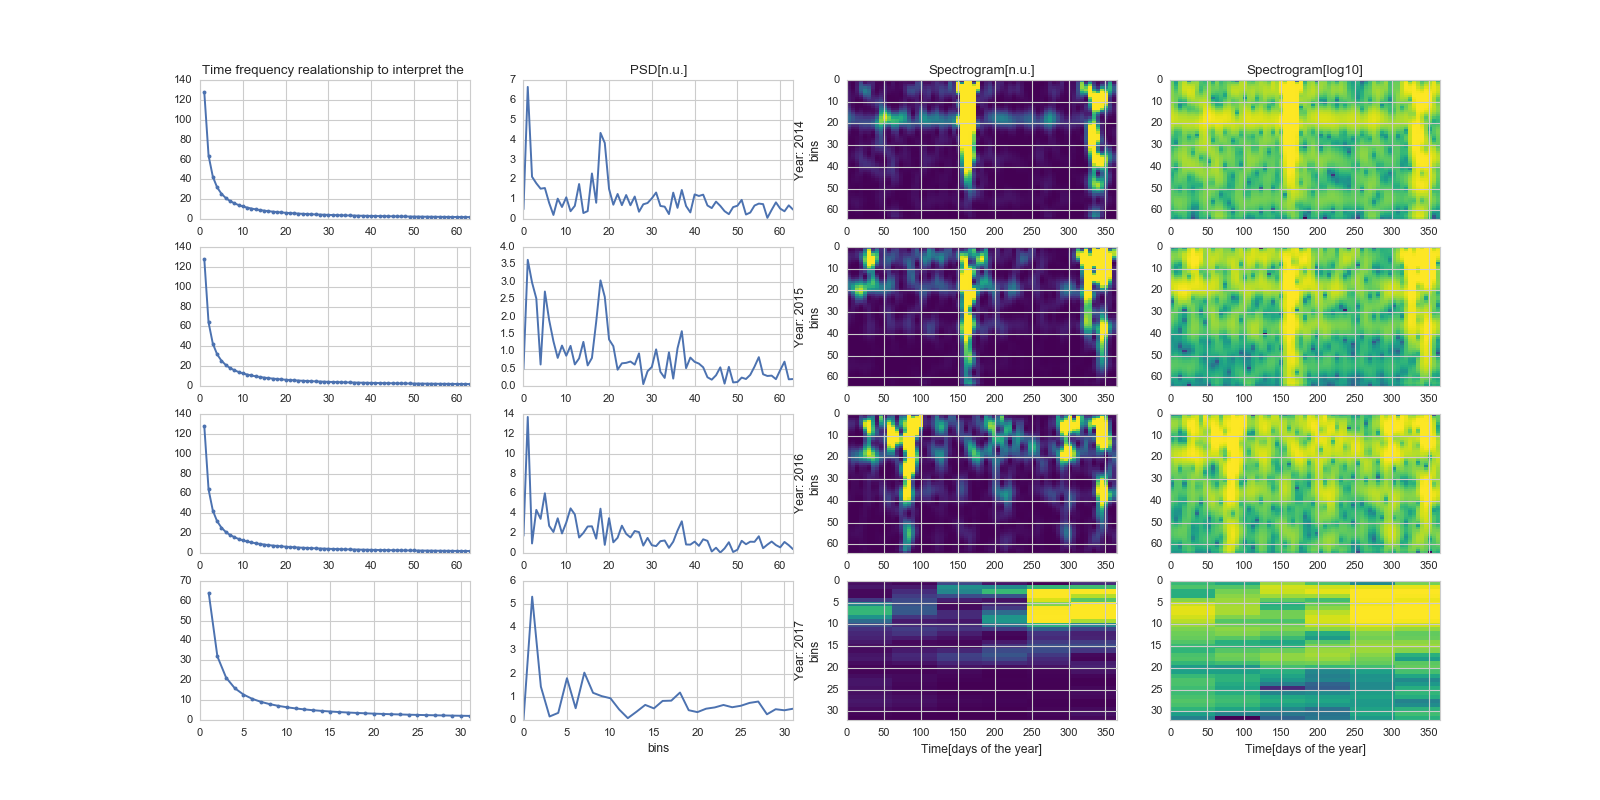

('fs', 1.1574074074074073e-05)


/home/javier/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in divide


In [14]:
# *****************************************************
# Computation of different spectral estimators per year for sign ups
years = np.unique(data.index.year)


# Definition of the figure.
figid = plt.figure('Spectral estimators per year32', figsize=(20, 10))

# Definition of the matrix of plots.
col = 4
rows = len(years)
gs = grds.GridSpec(rows,col)

#Spectral parameters
Window_length = 32 #in days
# This is equivalent to multitaper estimation but just one taper.
window = sgn.slepian(Window_length, width=0.3)
overlap = 0.85
T1= 24*60*60 # 1 day in seconds

fs = 1./T1
print('fs',fs)

   

for r in range(rows):
    ax01 = plt.subplot(gs[r, 0])
#     ax02 = plt.subplot(gs[r, 1])  
    ax1 = plt.subplot(gs[r, 1])
    ax2 = plt.subplot(gs[r, 2])
    ax3 = plt.subplot(gs[r, 3])

    dat = data['sups'][str(years[r])].values
    
    nfft=128
    if r==3:
        nfft=64
    
#     MODIFICATION with respect the original exercise
#     For the sake of clarity I just substract the "DC" component, the baseline or offset
#     spec = np.fft.fft(dat,n=nfft) #Original line
    spec = np.fft.fft(dat-np.mean(dat),n=nfft)
    n = nfft
    f = np.fft.fftfreq(n,T1)
    

    bins = np.ceil(np.arange(nfft/2))
    bins = bins.astype(int)
    peri = bins*fs/nfft

    ax01.plot(bins,((1./peri))/T1,'.-')
    ax01.set_xlim([bins[0],bins[-1]])
        
    
#     ax1.plot(np.abs(spec[0:np.ceil(len(spec)*1.0/2)]))
    ax1.plot(np.abs(spec[bins]))
    ax1.set_xlim([bins[0],bins[-1]])

    f, t, Sxx = sgn.spectrogram(dat-np.mean(dat),nfft=nfft,fs=fs,nperseg=Window_length,window=window,noverlap=np.round(Window_length*overlap))
    

    spec= np.abs(Sxx)
    
    ax2.imshow(spec,vmax=np.percentile(spec,95),aspect='auto',cmap='viridis',interpolation='none',extent=[0,365,nfft/2,0])
    ax3.imshow(np.log(spec),vmax=np.percentile(np.log(spec),95),aspect='auto',cmap='viridis',interpolation='none',extent=[0,365,nfft/2,0])

    
    
    ax2.set_ylabel('Year: '+str(years[r])+'\nbins',multialignment='center')
    
    if r==0:
        ax01.set_title('Time frequency realationship to interpret the ')
        ax1.set_title('PSD[n.u.]')
        ax2.set_title('Spectrogram[n.u.]')
        ax3.set_title('Spectrogram[log10]')

    if r==rows-1:
        ax1.set_xlabel('bins')
        ax2.set_xlabel('Time[days of the year]')
        ax3.set_xlabel('Time[days of the year]')

# Q2.2) Run the program on the data sample from PetFood, and comment on	the output

Once the function is called the results point clear to certain level of seasonality/ periodicity similar for the two first years and different for the last two years.

The temporal distributions per year shows that the 2014 and 2015 have a quite similar behaviour in the monthly scale and also in the day of the week. Two troughs can be observed in april/ may and october, while two peaks are visible at february and june. The first year with the new offline adds shows also two troughs and two peaks, the earliers as before april/may and october, but the later, the peaks, with a slightly shift now at february and july. 

Observing the PSD per year it is possible to observe peaks of activity at 0.15 $\mu Hz$ and 0.28 $\mu Hz$ for 2014. With a $f_s = \frac{1}{1day} Hz$ that is $f_s=11.574 \mu Hz$  this represent for the first case 1 cycle every 2.7 months, while the other peak means 1 cycle every 1.3 months. Despite of the peaks the PSD seems to have the main power concentrated around 0.1-0.09 which will mean 1 cycle every 3.8-4.2 months. This last observation is compatible with the observation in the previous plot. 

# <font color='red'>Modification. </font>

I was confused with the axis and the frequency temporal transformation. I corrected in the new calculations and I add a plot to translate the number of bin into days. This relationship is given by $binx[\frac{f_s}{nfft}]$. In these new calculations I took n=128 except for the last year nfft=64. The sampling rate was correct (sampling every day) that is $f_s=11.574 \mu Hz$. To translate this to days I need $binx[\frac{1}{nfft}*T_s]$ which is not lineal with respect the bin number.


At this point I prefer to plot the frequency axes in number of bins (horizontal axis for the PSD and vertical axis for the spectrograms) rather than in frequency (which at this time scale seems difficult to interpret) or a non-linear temporal scale. That is why I plot in the first column the function that relates the number of bin with the period in time(instead of frequency). Perhaps this is not common (at least is not common in my current field of knowledge but I work in a less than 1s scale....then is easier to interpret the Hz) but with this time scale I prefer this solution rather than the other two options for the sake of clarity to the customer. Then the customer or the person that has to analyze the data can zoom in/out in this plot to see the correspondence between the number of bin (horizontal axis) with the number of days(vertical axis). 


Taking this in account the previous explanation change dramatically and I apologize for this mistake, because in deed it was obvious from the crosscorrelations of the previous exercise that the period is in the range of days not months. Then:

* For 2014, there are two relevant peaks at the PSD, one at bin=1 (~120 days) and the other between bin=18 (this means ~6.8 days).The peak at 120 days reflects the tendency that is also visible in the temporal distribution of sign ups per month. In that plot it is possible to see how the wave shape is almost sinusoidal of period ~4 months. This periodicity does not show up in the spectrograms because those are computed with a window of 32 days and hence it can not capture events larger than that (for capturing then one should use a larger window).

    The periodicity at ~6.8 it is capture in both the PSD and the spectrogram and shows how relevant this band is except at two moments of the year, June and December. In June there is a peak at bin=30 (~4 days, this is the duration of the peak observed in the time series at that point. In November/December there is a peak at bin= 40 (~3 days) and another one a bit delayed at bin =10 (~11 days).
    
    All together the most important trends in this year are the one lasting 120 days (4 months) and the 6.8 days. 

* For 2015, we can observed from the PSD two peaks in the long temporal range at bin=1 (~120 days) and bin=5 (~25 days). This is an interesting change in the tendency that the Fourier analysis provides and is dificult to grasp at the time series. The band at bin=18 (~6.8 days)(with a peak in the PSD and a band in the spectrogram) is still relevant but observing the spectrograms it does not look as relevant as the previous year. At January there is a relevant peak but this is not stable throughout the year and itvanishs after february. 
    The previous peak in Juni shifted to a shorter time scale being the peak at bin =40 (~3 days). The situation in November/December is kind of similar but with one first event at bin ~7 (~18 days) and another one a bit layed at ~3 days.
    
* For 2016, the amplitude of the ~120 days peak from the PSD is even larger, such that obscure also other peaks (one thing to notice is that despite the period is the same, checking the temporal plot for the months it is obvious that the phase changed/shifted). The next peak is at bin=5 (~25 days); from the spectrograms this is specially relevant at the begining of the year but not after March. In this month there is a big deplexion of the power visible at the spectrograms. This deplexion mix three four bands bin=5(~25 days), bin=12 (~11 days), bin=15 (~8 days), bin =35 (~3.5 days) and bin=55 (~2.5 days). This mixture of pattern match a big investment in the Online advertisement.
    After this point the year oscillates between the bands of bin=15(~8 days) and bin=5(~25 days). 
    The event that before was in end of November seems anticipated one month to October having at that point two clear bands at bin=5(~25 days) and bin=18(~7 days). 
    In December there is also a peak of activity in the bands of bin=5(~25 days) and bin=35 (~3.5 days).
    
* For 2017, there is information for only two months but so far the tendency is to have a wide peak at bin=7 (~9.5 days) specially at the end of February. There is as the PSD points, a tendency of having a peak of activity at bin =1 (~30 days)


This results shows that the method is valid to capture the seasons of the sign ups time series. 
# <font color='red'>End of the modification. </font>

The PSD for 2015 shows less spiky activity but rather more power at 0.1 with a small peak at 0.28. It is important to note also that a lot of power, as also happened before with 2014, it is located around 0.05 which it translate in a cycle every, aprox, 7 months. This could suggest a general trend in that range.  

The PSD of 2016 shows also this weekly periodicity at around 7 days. The peak at 0.15 have changed here to a wider distribution, more peaky at 0.128 which means 1 cycle every 3 months (slower). The peak at 0.28 seems still present though. 

The PSD of 2017 has so few samples that is difficult to consider the estimator as good. Nonetheless one can take a llok and check the trends. The trend is that there is a distribution around 0.1 which means 3.85 months.

Observing the spectrograms the temporal seasons of the spectral componenets are much more clear. 2014 and 2015 share a common tendency of having a season of 0.1 at may/june and november. 2016 despite of having that compoonent too (a bit slower) it show it in april and november. Despite of that the three years have a clear component in the season befor christmas, having almost the same (a bit shifted) components for the range of november/december. 


This results shows that the method is valid to capture the seasons of the sign ups time series. 

# Q2.3) Discuss any additional methods and data sources that would be useful to improve the detection of cycles in the number of signups.

Fruther methods that could be explored:


* Multitaper estimator, this provides a better estimator.
* Wavelet estimator of the spectrum
* Phase relationships with Hilbert transform as support to extract the phase 
* The ideas of this paper, "Brain Oscillations and the Importance of Waveform Shape" http://www.cell.com/trends/cognitive-sciences/abstract/S1364-6613(16)30218-2?_returnURL=http%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1364661316302182%3Fshowall%3Dtrue


#  Q2.4) Discuss to what degree this same code solution can be expected to	work for a completely different customer, selling a	completely different product, in a different market. Would the approach	need to be adjusted to accommodate such a general setting?

The use of Fourier transform and the spectogram is a general approach to any time series. In that sense the method is agnostic to the customer, product or market; hence it is validity is appropriate for the task of getting insights into the cyclic dynamics of any system.

Despite of that the main concern that one should take when dealing with this spectral estimators is the method that one used because the parameters could have a big impact in the representation of the estimator. This happens also with the wavelet transform and is the fact of having trade off when using the technique. One critical point is the window for the spectrogram because there should be big enough to capture enough degrees of freedom but narrow to fit the characteristic of the oscillations that one wants to observe. The bias and variance of the estimator is also a matter of debate. 

None the less these are technical details that do not affect the customer. Only the data scientist must be aware of this situation and have wide open eyes to do not let these effects uncontrolled. 
